Convert our vocab dictionaries to hugging face format

In [1]:
from vocabulary_functions import vocab_json_to_HF_json
names = ["human_bpe_10000.json", "human_mutbpe_10000.json", "membrane_bpe_10000.json", "membrane_mutbpe_10000.json"]
for name in names:
    vocab_json_to_HF_json(f"./vocabs/internal/{name}", f"./vocabs/huggingface/HF_{name}")


In [11]:
from tokenizers import Tokenizer
start_path = "./vocabs/huggingface/"
tokenizer_list = { name[:-5]: Tokenizer.from_file(start_path + f"HF_{name}") for name in names }

Example agreement calculation for a single sequence

In [13]:
from vocabulary_functions import calc_agreement
example = "MNKNISYLLISKLILQNYFITGFVWSFFSFFSIFMAFEFNENLFIDCLVVFFNFYLSFTIVFIFLINILGGKSDKCFNILILTRVIYFLLFFYYFVLVIRYSFFDLNDGFYGFRFLYGLIAPFFILSPLFILDVRFRFNFLLCLICCFFEIIFCLFLIFLSDHSFLDRSYFFSIVVNSLLFSLIFPYFFSFLKKIKSLKLSQNNTLFSVCSWISVFFGLVFLIFFYLFF"
t1 = tokenizer_list["human_bpe_10000"].encode(example).tokens
t2 = tokenizer_list["human_mutbpe_10000"].encode(example).tokens
t3 = tokenizer_list["membrane_bpe_10000"].encode(example).tokens
t4 = tokenizer_list["membrane_mutbpe_10000"].encode(example).tokens
print(calc_agreement(t1, t2))
print(calc_agreement(t1, t3))
print(calc_agreement(t1, t4))
print(calc_agreement(t2, t3))
print(calc_agreement(t2, t4))
print(calc_agreement(t3, t4))

0.8191489361702128
0.45989304812834225
0.6739130434782609
0.4648648648648649
0.6923076923076923
0.46408839779005523


Load the large dataset

In [4]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split

with open('../../RSRC/uniref_taxonomy_id_9606_AND_identity_2024_09_13.json') as f:
    human_proteins_json = json.load(f)['results']
    
human_proteins_df = []
for prot in human_proteins_json:
    human_proteins_df.append({'id': prot['id'], 'sequence': prot['representativeMember']['sequence']['value']})
human_proteins_df = pd.DataFrame(human_proteins_df)
human_proteins_df = human_proteins_df[~human_proteins_df['sequence'].str.contains('U')]

df_ds_train, df_ds_test = train_test_split(human_proteins_df, test_size=0.2, random_state=42)

corpus = df_ds_train['sequence']


Batch agreement calculations

In [5]:
t1 = [enc.tokens for enc in tokenizer_list["human_bpe_10000"].encode_batch(corpus)]
t2 = [enc.tokens for enc in tokenizer_list["human_mutbpe_10000"].encode_batch(corpus)]
t3 = [enc.tokens for enc in tokenizer_list["membrane_bpe_10000"].encode_batch(corpus)]
t4 = [enc.tokens for enc in tokenizer_list["membrane_mutbpe_10000"].encode_batch(corpus)]
from statistics import mean, stdev
agreement1 = [calc_agreement(tl1, tl2) for tl1, tl2 in zip(t1, t2)]
agreement2 = [calc_agreement(tl1, tl2) for tl1, tl2 in zip(t1, t3)]
agreement3 = [calc_agreement(tl1, tl2) for tl1, tl2 in zip(t1, t4)]
agreement4 = [calc_agreement(tl1, tl2) for tl1, tl2 in zip(t2, t3)]
agreement5 = [calc_agreement(tl1, tl2) for tl1, tl2 in zip(t2, t4)]
agreement6 = [calc_agreement(tl1, tl2) for tl1, tl2 in zip(t3, t4)]
print(f"human_bpe vs human_mutbpe Mean: {mean(agreement1)}, Stdev: {stdev(agreement1)}")
print(f"human_bpe vs membrane_bpe Mean: {mean(agreement2)}, Stdev: {stdev(agreement2)}")
print(f"human_bpe vs membrane_mutbpe Mean: {mean(agreement3)}, Stdev: {stdev(agreement3)}")
print(f"human_mutbpe vs membrane_bpe Mean: {mean(agreement4)}, Stdev: {stdev(agreement4)}")
print(f"human_mutbpe vs membrane_mutbpe Mean: {mean(agreement5)}, Stdev: {stdev(agreement5)}")
print(f"membrane_bpe vs membrane_mutbpe Mean: {mean(agreement6)}, Stdev: {stdev(agreement6)}")

human_bpe vs human_mutbpe Mean: 0.7899111561748957, Stdev: 0.062473318624358176
human_bpe vs membrane_bpe Mean: 0.44014705777436214, Stdev: 0.0796439109197611
human_bpe vs membrane_mutbpe Mean: 0.5634344712439963, Stdev: 0.08013702288452824
human_mutbpe vs membrane_bpe Mean: 0.4171809463638218, Stdev: 0.07956892608012844
human_mutbpe vs membrane_mutbpe Mean: 0.5423314614882032, Stdev: 0.0845501187199612
membrane_bpe vs membrane_mutbpe Mean: 0.5481940490412491, Stdev: 0.08509814536184993


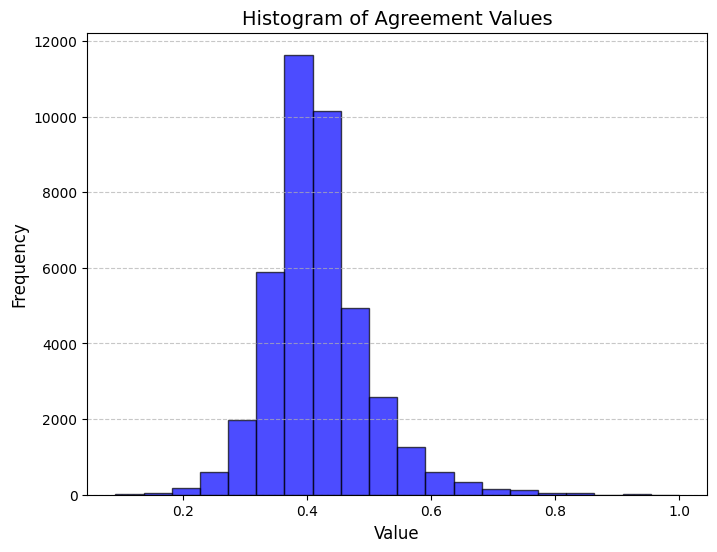

In [11]:
import matplotlib.pyplot as plt
bins = 20
plt.figure(figsize=(8, 6))
plt.hist(agreement4, bins=bins, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of Agreement Values', fontsize=14)
plt.xlabel('Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()